In [1]:
# =========================
# 11_visualization_and_interpretation.ipynb
# Goal: Summarize inference for each analysis — null rejection and reliability
# =========================

from pathlib import Path
import re
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display/plot defaults (consistent with earlier notebooks)
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 60)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# -------------------------
# Paths
# -------------------------
ROOT = Path("..")
REPORT_MODELS = ROOT / "reports" / "models"
REPORT_TABLES = ROOT / "reports" / "tables" / "models"
FIG_DIR = ROOT / "reports" / "figures" / "interpretation"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name: str, exts=("png","svg")):
    fig = plt.gcf()
    fig.tight_layout()
    for ext in exts:
        fig.savefig(FIG_DIR / f"{name}.{ext}", dpi=150 if ext=="png" else None, bbox_inches="tight")

# Event reference dates (kept for consistency; used elsewhere if needed)
EVENT_V3_LAUNCH = dt.date(2021, 5, 5)
EVENT_FTX       = dt.date(2022, 11, 10)

def add_event_vlines(ax, show_legend=True):
    v3  = ax.axvline(EVENT_V3_LAUNCH, linestyle="--", linewidth=1, color="tab:blue",
                     label="Uniswap v3 launch (2021-05-05)")
    ftx = ax.axvline(EVENT_FTX,       linestyle="--", linewidth=1, color="tab:red",
                     label="FTX collapse (2022-11-10)")
    if show_legend:
        ax.legend(handles=[v3, ftx], frameon=False, loc="upper left")
    return ax

In [2]:
# -------------------------
# Helpers to read outputs
# -------------------------
def read_coefs(stem: str) -> pd.DataFrame:
    """Load tidy coefficient table saved as parquet."""
    p = REPORT_MODELS / f"{stem}_coefs.parquet"
    if not p.exists():
        raise FileNotFoundError(p)
    df = pd.read_parquet(p)
    # Expected columns: term, estimate, std_error, t_value, p_value, conf_low, conf_high, model
    return df

def read_summary(stem: str) -> str:
    """Load text summary (statsmodels .summary())."""
    p = REPORT_TABLES / f"{stem}_summary.txt"
    return p.read_text(encoding="utf-8") if p.exists() else ""

def parse_n_r2(summary_text: str):
    """Best-effort parse of nobs and R-squared from statsmodels summary text."""
    if not summary_text:
        return None, None
    nobs = None
    r2 = None
    m = re.search(r"Number of observations:\s*([0-9,\.]+)", summary_text, re.I)
    if m:
        try: nobs = float(m.group(1).replace(",",""))
        except: pass
    m = re.search(r"R-squared:\s*([0-9\.]+)", summary_text, re.I)
    if m:
        try: r2 = float(m.group(1))
        except: pass
    if nobs is None:
        m = re.search(r"n=\s*([0-9,\.]+)", summary_text, re.I)
        if m:
            try: nobs = float(m.group(1).replace(",",""))
            except: pass
    return nobs, r2

def star(p):
    if pd.isna(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def pick_term(df: pd.DataFrame, contains_all: list[str] = None, exact: str = None):
    """
    Find a coefficient row by exact term or by requiring all substrings (literal match).
    Prefers non-FE terms (excludes C(label)/C(date) dummies) when multiple hits exist.
    Returns the first matching row (as a Series) or None.
    """
    if "term" not in df.columns or df.empty:
        return None

    # Exact match first (fast path)
    if exact is not None:
        m = (df["term"] == exact)
        if m.any():
            return df.loc[m].iloc[0]

    # Require all substrings (literal contains; no regex)
    if contains_all:
        mask = pd.Series(True, index=df.index)
        for s in contains_all:
            mask &= df["term"].str.contains(s, regex=False, na=False)
        hits = df.loc[mask]

        if len(hits) >= 1:
            # Prefer non-FE coefficients (exclude C(label), C(date) dummies)
            fe_mask = (hits["term"].str.contains("C(label)", regex=False, na=False) |
                       hits["term"].str.contains("C(date)",  regex=False, na=False))
            non_fe = hits.loc[~fe_mask]
            if not non_fe.empty:
                return non_fe.iloc[0]
            return hits.iloc[0]

    return None

def interpret(sign_expected: str, est: float, p: float):
    """
    sign_expected: 'pos', 'neg', or 'any'
    Returns a concise verdict string.
    """
    if pd.isna(est) or pd.isna(p):
        return "inconclusive (coef/p missing)"
    sig = p < 0.05
    direction_ok = (sign_expected == "any" or
                    (sign_expected == "pos" and est > 0) or
                    (sign_expected == "neg" and est < 0))
    if sig and direction_ok:
        return "reject H0 at 5% (sign as hypothesized)"
    if sig and not direction_ok:
        return "reject H0 at 5% (sign opposite)"
    return "fail to reject H0 (p≥0.05)"

def reliability_note(nobs, r2, clustered="label"):
    bits = []
    if nobs is not None: bits.append(f"n={int(nobs)}")
    if r2 is not None:   bits.append(f"R²={r2:.3f}")
    bits.append(f"SE clustered by {clustered}")
    return " | ".join(bits)

In [3]:
# -------------------------
# Inventory of analyses (A1–A8 implemented)
# -------------------------
ANALYSES = [
    # A1
    dict(code="fe_logvol_v3share", label="A1: DEX activity vs v3 adoption (TWFE)",
         target=("pos", {"exact": "v3_share_filled"})),
    # A2
    dict(code="fe_absret_v3share_cex", label="A2: Spillovers to CEX volatility (TWFE)",
         target=("neg", {"exact": "v3_share_filled"})),
    # A3 (CEX microstructure, per proxy) → focus on log_volumeUSD effect
    dict(code="fe_cex_proxy_roll",   label="A3: CEX microstructure — Roll",
         target=("neg", {"exact": "log_volumeUSD"})),
    dict(code="fe_cex_proxy_chl",    label="A3: CEX microstructure — CHL",
         target=("neg", {"exact": "log_volumeUSD"})),
    dict(code="fe_cex_proxy_cs",     label="A3: CEX microstructure — Corwin–Schultz",
         target=("neg", {"exact": "log_volumeUSD"})),
    dict(code="fe_cex_proxy_amihud", label="A3: CEX microstructure — Amihud",
         target=("neg", {"exact": "log_volumeUSD"})),
    # A4 (DEX proxies vs activity)
    dict(code="fe_dex_proxy_amihud", label="A4: DEX microstructure — Amihud",
         target=("neg", {"exact": "log_volumeUSD"})),
    dict(code="fe_dex_proxy_roll",   label="A4: DEX microstructure — Roll",
         target=("neg", {"exact": "log_volumeUSD"})),
    # A5 (DiD: interaction term)
    dict(code="did1_v3launch_logvol_dex_vs_cex", label="A5: DiD — v3 launch (DEX vs CEX)",
         target=("pos", {"contains_all": ["is_dex", "post_v3"]})),
    # A6 (event study — handled by plot section; no single target term)
    dict(code="did1_v3launch_eventstudy_logvol_dex_only", label="A6: Event study — v3 launch (DEX only)",
         target=None),
    # A7 (DiD: interaction term)
    dict(code="did2_ftx_logvol_dex_vs_cex", label="A7: DiD — FTX (DEX vs CEX)",
         target=("pos", {"contains_all": ["is_dex", "post_ftx"]})),
    # A8 (event study — handled by plot section; no single target term)
    dict(code="did2_ftx_eventstudy_logvol_dex_only", label="A8: Event study — FTX (DEX only)",
         target=None),
]

In [4]:
# -------------------------
# Run interpretation (table)
# -------------------------
rows = []
for a in ANALYSES:
    code  = a["code"]
    label = a["label"]
    target = a.get("target", None)   # None for event studies (A6, A8)

    # Load outputs
    try:
        coefs = read_coefs(code)
    except FileNotFoundError:
        rows.append(dict(analysis=label, model=code,
                         term="(missing)", estimate=np.nan, p_value=np.nan,
                         verdict="output not found", reliability=""))
        continue

    summ_txt = read_summary(code)
    nobs, r2 = parse_n_r2(summ_txt)

    # Event studies don't have a single "target" term to read
    if target is None:
        rows.append(dict(
            analysis=label,
            model=code,
            term="(event-study bins)",
            estimate=np.nan,
            p_value=np.nan,
            verdict="see event-study plot (bin profile)",
            reliability=reliability_note(nobs, r2)
        ))
        continue

    # Otherwise, find the primary coefficient to interpret
    sign_expected, finder = target
    term_row = None
    if isinstance(finder, dict):
        if "exact" in finder and finder["exact"] is not None:
            term_row = pick_term(coefs, exact=finder["exact"])
        elif "contains_all" in finder and finder["contains_all"] is not None:
            term_row = pick_term(coefs, contains_all=finder["contains_all"])

    if term_row is None:
        rows.append(dict(analysis=label, model=code,
                         term="(term not found)", estimate=np.nan, p_value=np.nan,
                         verdict="inconclusive (term not found)",
                         reliability=reliability_note(nobs, r2)))
        continue

    est = float(term_row.get("estimate", np.nan))
    p   = float(term_row.get("p_value", np.nan))
    verdict = interpret(sign_expected, est, p)

    rows.append(dict(
        analysis=label,
        model=code,
        term=str(term_row["term"]),
        estimate=est,
        p_value=p,
        stars=star(p),
        verdict=verdict,
        reliability=reliability_note(nobs, r2)
    ))

interp = pd.DataFrame(rows)
display(interp[["analysis","term","estimate","p_value","stars","verdict","reliability"]])

,analysis,term,estimate,p_value,stars,verdict,reliability
0,A1: DEX activity vs v3 adoption (TWFE),v3_share_filled,1.218821,0.000536,***,reject H0 at 5% (sign as hypothesized),R²=0.355 | SE clustered by label
1,A2: Spillovers to CEX volatility (TWFE),v3_share_filled,0.001054,0.777995,,fail to reject H0 (p≥0.05),R²=0.347 | SE clustered by label
2,A3: CEX microstructure — Roll,log_volumeUSD,0.001581,0.024403,**,reject H0 at 5% (sign opposite),R²=0.614 | SE clustered by label
3,A3: CEX microstructure — CHL,log_volumeUSD,0.001081,0.011729,**,reject H0 at 5% (sign opposite),R²=0.484 | SE clustered by label
4,A3: CEX microstructure — Corwin–Schultz,log_volumeUSD,0.022163,0.006004,***,reject H0 at 5% (sign opposite),R²=0.590 | SE clustered by label
5,A3: CEX microstructure — Amihud,log_volumeUSD,-0.000408,0.041853,**,reject H0 at 5% (sign as hypothesized),R²=0.173 | SE clustered by label
6,A4: DEX microstructure — Amihud,log_volumeUSD,-0.853576,0.326674,,fail to reject H0 (p≥0.05),R²=0.018 | SE clustered by label
7,A4: DEX microstructure — Roll,log_volumeUSD,-0.009711,0.186369,,fail to reject H0 (p≥0.05),R²=0.040 | SE clustered by label
8,A5: DiD — v3 launch (DEX vs CEX),is_dex:post_v3,-1.854697,0.000002,***,reject H0 at 5% (sign opposite),R²=0.494 | SE clustered by label
9,A6: Event study — v3 launch (DEX only),(event-study bins),NaN,NaN,NaN,see event-study plot (bin profile),R²=0.324 | SE clustered by label


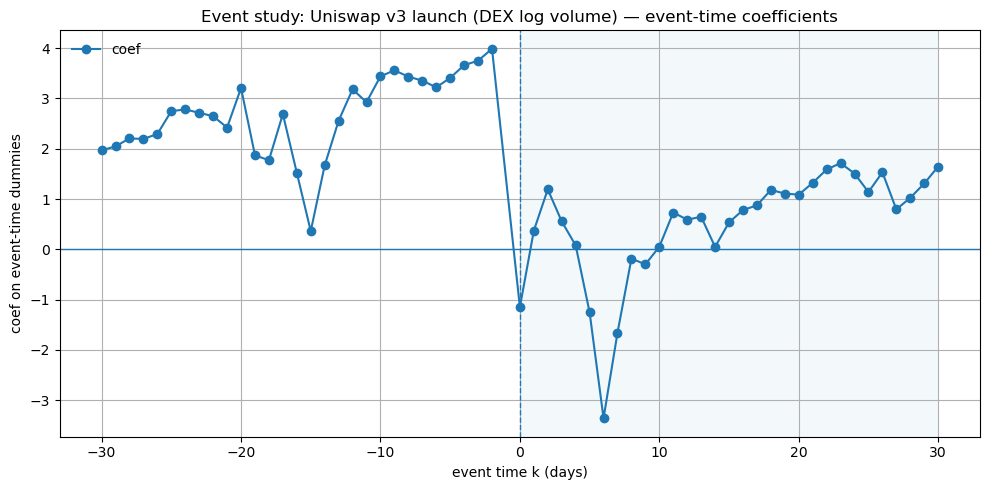

[did1_v3launch_eventstudy_logvol_dex_only] v3 launch (2021-05-05): pretrend sig-share=0.97, post sig-share=0.53


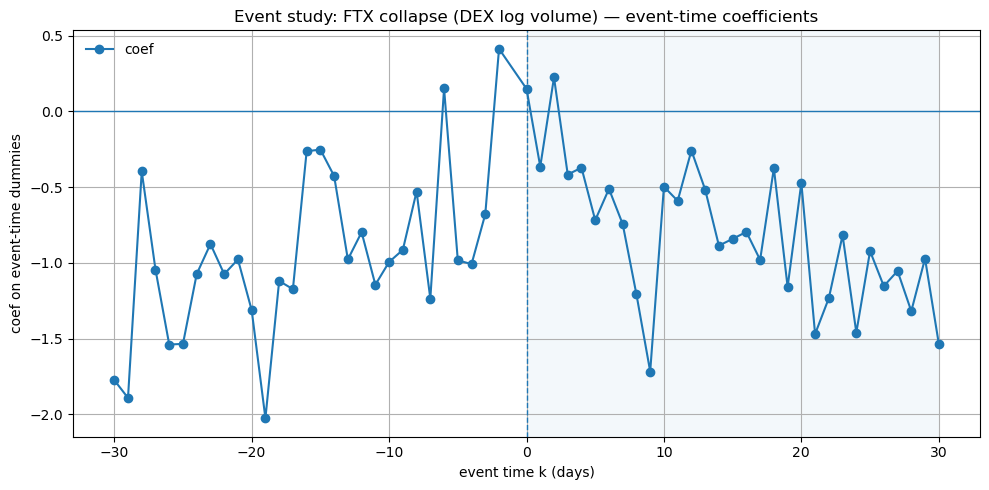

[did2_ftx_eventstudy_logvol_dex_only] FTX collapse (2022-11-10): pretrend sig-share=0.76, post sig-share=0.63


In [5]:
# -------------------------
# Event-study visuals + pretrend/post summaries (A6 & A8)
# -------------------------
def event_study_summary_and_plot(code: str, title: str, event_name: str):
    coefs = read_coefs(code)

    # Pick event-time bin terms (warning-safe regex)
    bin_mask = (
        coefs["term"].str.contains(r"(?:lead|lag)", case=False, regex=True)
        | coefs["term"].str.contains(r"tau_.*-?\d+", case=False, regex=True)
        | coefs["term"].str.contains(r"k[_=]-?\d+", case=False, regex=True)
        | coefs["term"].str.contains(r"post_\d+", case=False, regex=True)
        | coefs["term"].str.contains(r"D_tau_[mp]\d+", case=False, regex=True)
    )

    # Drop FE and control terms
    drop_ctrl = coefs["term"].str.contains(
        r"C\(label\)|C\(date\)|eth_|log_volumeUSD|v3_share|is_dex:post_|is_dex$|^post_(?:v3|ftx)$",
        case=False, regex=True
    )

    bins = coefs.loc[bin_mask & ~drop_ctrl, ["term","estimate","p_value"]].copy()

    # If CIs exist, include them; else plot without yerr
    for c in ["conf_low", "conf_high"]:
        if c in coefs.columns:
            bins[c] = coefs.loc[bin_mask & ~drop_ctrl, c].values

    if bins.empty:
        print(f"[info] no recognizable event bins in {code}; skipping plot.")
        return

    # Parse numeric event time k (supports multiple naming schemes)
    def parse_k(term: str):
        # 1) D_tau_m10 -> -10, D_tau_p10 -> +10, D_tau_p0 -> 0
        m = re.search(r"D_tau_(m|p)(\d+)", term, flags=re.I)
        if m:
            sign = -1 if m.group(1).lower() == "m" else 1
            return sign * int(m.group(2))
        # 2) tau_-10
        m = re.search(r"tau_.*?(-?\d+)", term, flags=re.I)
        if m:
            return int(m.group(1))
        # 3) k_+5 or k=-3
        m = re.search(r"k[_=]\s*([+-]?\d+)", term, flags=re.I)
        if m:
            return int(m.group(1))
        # 4) post_5 (treated as positive)
        m = re.search(r"post_(\d+)", term, flags=re.I)
        if m:
            return int(m.group(1))
        # 5) fallback: first integer
        m = re.search(r"([+-]?\d+)", term)
        return int(m.group(1)) if m else None

    bins["k"] = bins["term"].map(parse_k)
    bins = bins.dropna(subset=["k"]).sort_values("k")
    if bins.empty:
        print(f"[info] cannot parse k from terms in {code}; skipping plot.")
        return

    # Pre/post significance shares
    pre  = bins.loc[bins["k"] < 0]
    post = bins.loc[bins["k"] > 0]
    pre_sig_share  = float((pre["p_value"]  < 0.05).mean()) if not pre.empty  else np.nan
    post_sig_share = float((post["p_value"] < 0.05).mean()) if not post.empty else np.nan

    # Plot
    ax = plt.gca()
    ax.axhline(0, linewidth=1)
    ax.axvline(0, linestyle="--", linewidth=1)
    ax.axvspan(0, bins["k"].max(), alpha=0.05)
    if {"conf_low","conf_high"}.issubset(bins.columns):
        yerr = [bins["estimate"] - bins["conf_low"], bins["conf_high"] - bins["estimate"]]
        ax.errorbar(bins["k"], bins["estimate"], yerr=yerr, fmt="o-", label="coef ± 95% CI")
    else:
        ax.plot(bins["k"], bins["estimate"], "o-", label="coef")
    ax.set_title(f"{title} — event-time coefficients")
    ax.set_xlabel("event time k (days)")
    ax.set_ylabel("coef on event-time dummies")
    ax.legend(frameon=False, loc="upper left")
    savefig(f"{code}_eventstudy")
    plt.show()

    print(f"[{code}] {event_name}: pretrend sig-share={pre_sig_share:.2f}, post sig-share={post_sig_share:.2f}")

# A6: v3 launch (DEX only)
try:
    event_study_summary_and_plot(
        "did1_v3launch_eventstudy_logvol_dex_only",
        "Event study: Uniswap v3 launch (DEX log volume)",
        "v3 launch (2021-05-05)"
    )
except Exception as e:
    print(f"[warn] v3 event-study plot skipped: {e}")

# A8: FTX (DEX only)
try:
    event_study_summary_and_plot(
        "did2_ftx_eventstudy_logvol_dex_only",
        "Event study: FTX collapse (DEX log volume)",
        "FTX collapse (2022-11-10)"
    )
except Exception as e:
    print(f"[warn] FTX event-study plot skipped: {e}")

In [6]:
# -------------------------
# Quick written takeaways (auto from table)
# -------------------------
def quick_takeaways(df: pd.DataFrame):
    out = []
    for _, r in df.iterrows():
        est = r['estimate']
        est_str = "NaN" if pd.isna(est) else f"{est:.3g}"
        bullet = (f"- {r['analysis']}: term={r['term']} "
                  f"est={est_str}{r.get('stars','')} | {r['verdict']} "
                  f"({r['reliability']})")
        out.append(bullet)
    return "\n".join(out)

print("\n== Quick takeaways ==")
print(quick_takeaways(interp))


== Quick takeaways ==
- A1: DEX activity vs v3 adoption (TWFE): term=v3_share_filled est=1.22*** | reject H0 at 5% (sign as hypothesized) (R²=0.355 | SE clustered by label)
- A2: Spillovers to CEX volatility (TWFE): term=v3_share_filled est=0.00105 | fail to reject H0 (p≥0.05) (R²=0.347 | SE clustered by label)
- A3: CEX microstructure — Roll: term=log_volumeUSD est=0.00158** | reject H0 at 5% (sign opposite) (R²=0.614 | SE clustered by label)
- A3: CEX microstructure — CHL: term=log_volumeUSD est=0.00108** | reject H0 at 5% (sign opposite) (R²=0.484 | SE clustered by label)
- A3: CEX microstructure — Corwin–Schultz: term=log_volumeUSD est=0.0222*** | reject H0 at 5% (sign opposite) (R²=0.590 | SE clustered by label)
- A3: CEX microstructure — Amihud: term=log_volumeUSD est=-0.000408** | reject H0 at 5% (sign as hypothesized) (R²=0.173 | SE clustered by label)
- A4: DEX microstructure — Amihud: term=log_volumeUSD est=-0.854 | fail to reject H0 (p≥0.05) (R²=0.018 | SE clustered by labe